On effectue le pricing de plusieurs options dans le modèle de Jacobi.

In [1]:
# Some useful imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import eval_hermitenorm, factorial
from scipy.stats import norm
from scipy.linalg import expm


from scipy.special import eval_hermitenorm, factorial
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import expm_multiply

On commence par pricer un call.

In [ ]:
class JacobiPricing:
    def __init__(self, V0, X0, v_min, v_max, sigma, rho, kappa, theta, delta, mu_w, sigma_w, r):
        self.V0 = V0
        self.X0 = X0
        self.v_min = v_min
        self.v_max = v_max
        self.sigma = sigma
        self.rho = rho
        self.kappa = kappa
        self.theta = theta
        self.delta = delta
        self.mu_w = mu_w
        self.sigma_w = sigma_w
        self.r = r

    def I_call(self, N, mu, nu):
        res = np.zeros(N+1)
        res[0] = np.exp(nu**2/2) * norm.cdf(nu-mu)
        for i in range(1, N+1):
            res[i] = eval_hermitenorm(i-1, mu) * np.exp(mu*nu) * norm.pdf(mu) + nu * res[i-1]
        return res

    def f_call(self, N, k, T):
        mu = (k-self.mu_w) / self.sigma_w
        nu = self.sigma_w
        I = self.I_call(N, mu, nu)
        f = np.zeros(N+1)
        f[0] = np.exp(-self.r*T+self.mu_w) * I[0] - np.exp(-self.r*T+k) * norm.cdf(-mu)
        for i in range(1, N+1):
            f[i] = np.exp(-self.r*T+self.mu_w) * (1/np.sqrt(factorial(i, exact=False))) * self.sigma_w * I[i-1]
        return f
    
    def pi(self, N):
        p = 0
        h = {}
        h_inv = []
        for d in range(0, N+1):
            for i in range(0, d+1):
                h[(i, d-i)] = p
                h_inv.append((i, d-i))
                p += 1
        return h, np.array(h_inv)
    
    def H(self, m, n, v, x):
        return (v**m) * (1/np.sqrt(factorial(n, exact=False))) * eval_hermitenorm(n, (x-self.mu_w)/self.sigma_w)

    def l_call(self, N, T):
        M = (N+1) * (N+2) // 2
        h, h_inv = self.pi(N)
        l = np.zeros(N+1)

        H_lst = np.zeros(M)
        for i in range(M):
            (m, n) = h_inv[i]
            H_lst[i] = self.H(m, n, self.V0, self.X0)

        # Matrix G
        G = np.zeros((M, M))
        for d in range(0, N+1):
            for i in range(0, d+1):
                (m, n) = (i, d-i)
                if m >= 2:
                    G[h[(m-2,n)], h[(m,n)]] = -self.sigma**2 * m * (m-1) * self.v_max * self.v_min / (2 * (np.sqrt(self.v_max) - np.sqrt(self.v_min))**2)
                if m >=1 and n >= 1:
                    G[h[(m-1,n-1)], h[(m,n)]] = -self.sigma * self.rho * m * np.sqrt(n) * self.v_min * self.v_max / (self.sigma_w * (np.sqrt(self.v_max) - np.sqrt(self.v_min))**2)
                if m >= 1:
                    G[h[(m-1,n)], h[(m,n)]] = self.kappa * self.theta * m + (self.sigma**2 * m * (m-1) * (self.v_min + self.v_max)) / (2 * (np.sqrt(self.v_max) - np.sqrt(self.v_min))**2)
                if n >= 1:
                    G[h[(m,n-1)], h[(m,n)]] = (self.r-self.delta)*np.sqrt(n)/self.sigma_w + (self.sigma*self.rho*m*np.sqrt(n)*(np.sqrt(self.v_min)+np.sqrt(self.v_max))) / (self.sigma_w*(np.sqrt(self.v_max)-np.sqrt(self.v_min))**2)
                if n >=2 and m <= N-1:
                    G[h[(m+1,n-2)], h[(m,n)]] = np.sqrt(n*(n-1)) / (2 * self.sigma_w**2)
                G[h[(m,n)], h[(m,n)]] = -self.kappa * m - (self.sigma**2 * m * (m-1)) / (2*(np.sqrt(self.v_max) - np.sqrt(self.v_min))**2)
                if n >=1 and m <= N-1:
                    G[h[(m+1,n-1)], h[(m,n)]] = - np.sqrt(n) / (2*self.sigma_w) - (self.sigma * self.rho * m * np.sqrt(n)) / (2*(np.sqrt(self.v_max)-np.sqrt(self.v_min))**2)

        E = np.zeros((M, N+1))
        for i in range(N+1):
            E[h[(0, i)], i] = 1
        G_exp = expm(T * G) 

        l = H_lst @ G_exp @ E

        return l
    
    def price_call(self, N, k, T):
        f = self.f_call(N, k, T)
        l = self.l_call(N, T)
        return np.dot(f, l)



N=2 Prix call = -0.013944874155448261
N=5 Prix call = 0.16818396362552918
N=8 Prix call = 0.10617345981020763
N=10 Prix call = 0.0963173090281351
N=15 Prix call = 0.0834533673005592
N=20 Prix call = 0.07135889894191694
N=25 Prix call = 0.06588579212072171
N=30 Prix call = 0.05973966339629938
N=35 Prix call = 0.056582159837346116
N=40 Prix call = 0.05274364925122147
N=50 Prix call = 0.04796885360209763
N=60 Prix call = 0.04445681624480101
N=70 Prix call = 0.04174108826055109


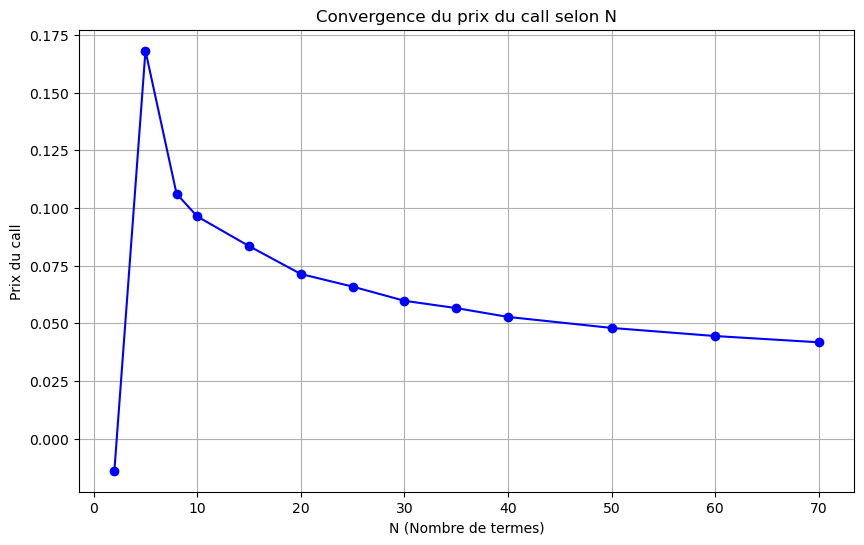

In [ ]:
V0 = 0.04
X0 = 0.
v_min = 10**(-4)
v_max = 0.08
sigma = 1.
rho = -0.5
kappa = 0.5
theta = 0.04
delta = 0.
k = 0.
T = 1/12
r = 0.

E_Vt = (V0 - theta) * (1 - np.exp(-kappa * T)) / kappa + theta
    
# Espérance de Q(V_t) (approximation via Q(E[V_t]))
sqrt_diff = (np.sqrt(v_max) - np.sqrt(v_min)) ** 2
E_Q_Vt = ((E_Vt - v_min) * (v_max - E_Vt)) / sqrt_diff

# mu_w = E[X_T]
mu_w = X0 + (r - delta) * T - 0.5 * ((V0 - theta) * (1 - np.exp(-kappa * T)) / kappa + theta * T)

# sigma_w^2 = Var[X_T]
sigma_w2 = T * (E_Vt + rho**2 * E_Q_Vt)
sigma_w = np.sqrt(sigma_w2)

sigma_w = sigma
mu_w = 0.01

model = JacobiPricing(V0, X0, v_min, v_max, sigma, rho, kappa, theta, delta, mu_w, sigma_w, r)

Ns = []
call_prices = []

for N in [2, 5, 8, 10, 15, 20, 25, 30, 35, 40, 50, 60, 70, 100, 150]:
    prix_call = model.price_call(N, k, T)
    Ns.append(N)
    call_prices.append(prix_call)
    print(f"N={N} Prix call = {prix_call}")

# Tracé du graphe
plt.figure(figsize=(10, 6))
plt.plot(Ns, call_prices, marker='o', linestyle='-', color='blue')
plt.xlabel("N (Nombre de termes)")
plt.ylabel("Prix du call")
plt.title("Convergence du prix du call selon N")
plt.show()